## ATGreen - Sample filtering and data validation
In this notebook, we perform the filtering of the sample of cities to be included in the analysis.
The filtering is a two-step process:

- First, we only retain those cities that have at least 20 green features in the raw osm files. 
- Second, we compare the green mean squarres intensity observable from the satellite images (ESA WC 2020) and OpenStreetMap. Using clustering analysis, we then identify those set of cities worlwide for which the difference in the green intensity among the two data sources is comparable to what observed for a set of european and north-american cities, here used as reference dataset. A detailed description of the approach is provided in the supplementary material of the manuscript. 

In [ ]:
# First import required packages
from atgreen import *
from tqdm import tqdm
import ast
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

PATH=''
os.chdir(PATH)

db_params=pickle.load(open(f"{PATH}/dicts/db_params.pickle", 'rb'))
city_country_ISO=pickle.load(open(f"{PATH}/dicts/city_country_ISO.pickle", 'rb'))
ISO_to_continent=pickle.load(open(f"{PATH}/dicts/osmfile_ISO.pickle", 'rb'))
filename_dict=pickle.load(open(f"{PATH}/dicts/city_names_final.pickle", 'rb'))
filename_dict_reverse={v: k for k, v in filename_dict.items()}

#### Load list of cities in our sample before performing the data validation and sample filtring

In [ ]:
cities_list=query_table(column='city', table='cities_boundary', schema='public', db_params=db_params)

#### Define rules for selection of cities

##### Rule 1 (R1) : Cities must have at least 20 green areas (in raw osm file)

In [ ]:
cities_satysfyingR1=[]
cities_notsatysfyingR1=[]

for city in tqdm(cities_list):
    try:
        df=query4osm2polygons(city, 'category', ['parks', 'forests', 'grass'], db_params)
        if len(df)>10:
            cities_satysfyingR1.append(city)
        else:
            cities_notsatysfyingR1.append(city)
    except: # If the table does not exist it means that there was no green in osm.
        cities_notsatysfyingR1.append(city)

#Save lists
pd.DataFrame({'city':cities_satysfyingR1}).to_csv(f"{PATH}/output/dataValidation/CitiesSatisfyingR1.csv")
pd.DataFrame({'city':cities_notsatysfyingR1}).to_csv(f"{PATH}/output/dataValidation/CitiesNotSatisfyingR1.csv")

##### Rule 2 (R2): sufficient similarity in green intensity between ESA WC 2020 and OpenStreetMap.

###### Load set of cities satisfying R1

In [3]:
cities_satysfyingR1=list(pd.read_csv(f"{PATH}/output/dataValidation/CitiesSatisfyingR1.csv")['city'])
len(cities_satysfyingR1)

1963

###### Compute mean squares difference among the two data sources (over normalized scale)

In [ ]:
import matplotlib.pyplot as plt

def mean_squares(df_orig, int1, int2, norm_factor):
    df=df_orig.copy()
    df['diff_squares']=df.apply(lambda x: ((x[int1]/norm_factor)-(x[int2]/norm_factor))**2, axis=1)
    ms=df['diff_squares'].mean()
    return ms, df


for ind,city in tqdm(enumerate(cities_satysfyingR1)):
    
    print(city)
    #Load remapped files (remapped to population grid) [ESA, OSM green and OSM green confounders]    
    pop_grid=query4grid(city, db_params)
    esa=queryRemappedGreen(city, "esa.esa2grid", '0_', 0, 0, db_params)
    osm=queryRemappedGreen(city, "osm.osm2grid", '0_', 0, 0, db_params)
    osm_confounders=queryRemappedGreen(city, "osm.osmconfounders2grid", '', 0, 0, db_params)
    osm_full=pd.concat([osm, osm_confounders])

    #Inbound only
    tmp_esa=pd.merge(pop_grid[pop_grid['inbound']==1][['x', 'y']], esa.groupby(['x', 'y']).sum().reset_index(), on=['x', 'y'], how='left')
    tmp_osm=pd.merge(pop_grid[pop_grid['inbound']==1][['x', 'y']], osm_full.groupby(['x', 'y']).sum().reset_index(), on=['x', 'y'], how='left')
    tmp=pd.merge(tmp_esa, tmp_osm, on=['x', 'y'], how='outer', suffixes=('_esa', '_osm'))
    tmp=tmp.fillna(0)

    norm_factor=max(tmp['si_esa'].max(), project_gdf(pop_grid).area[0]/10000)
    tmp.loc[tmp['si_osm']>norm_factor,'si_osm']=norm_factor
    ms, tmp =mean_squares(tmp, 'si_esa', 'si_osm', norm_factor)
    ms_norm=1-(ms)
    
    quality=pd.merge(pop_grid[pop_grid['inbound']==1][['x', 'y', 'population']], tmp[['x', 'y', 'si_esa', 'si_osm','diff_squares']], on=['x', 'y'], how='left')
    
    pct_list=[0, 10, 20, 30, 40, 50, 60, 70, 80 , 90]
    base=list(np.percentile(quality['population'], pct_list))
    values=[1-quality[quality['population']>=b]['diff_squares'].mean() for b in base]
    
    df=pd.DataFrame({'city':[city], 
                     'ISO':[city_country_ISO[filename_dict_reverse[city]]],
                     'mean_squares_error':[ms],
                     'mean_squares_error_norm':[ms_norm],
                     'percentile_list':[pct_list],
                     'base_list':[base],
                     'values_list':[values]})
    if ind == 0:
        df.to_csv(f"{PATH}/output/dataValidation/dataValiadtion_meansquareserror.csv", mode='w', index=False)
 
    else:
        df.to_csv(f"{PATH}/output/dataValidation/dataValiadtion_meansquareserror.csv", mode='a', header=False, index=False)

###### Generate figure

In [4]:
### Cities for figure
cities=['Caracas','Philadelphia','Boston', 'Vienna', 'London', 'Lisbon','Istanbul','Mexico_City']

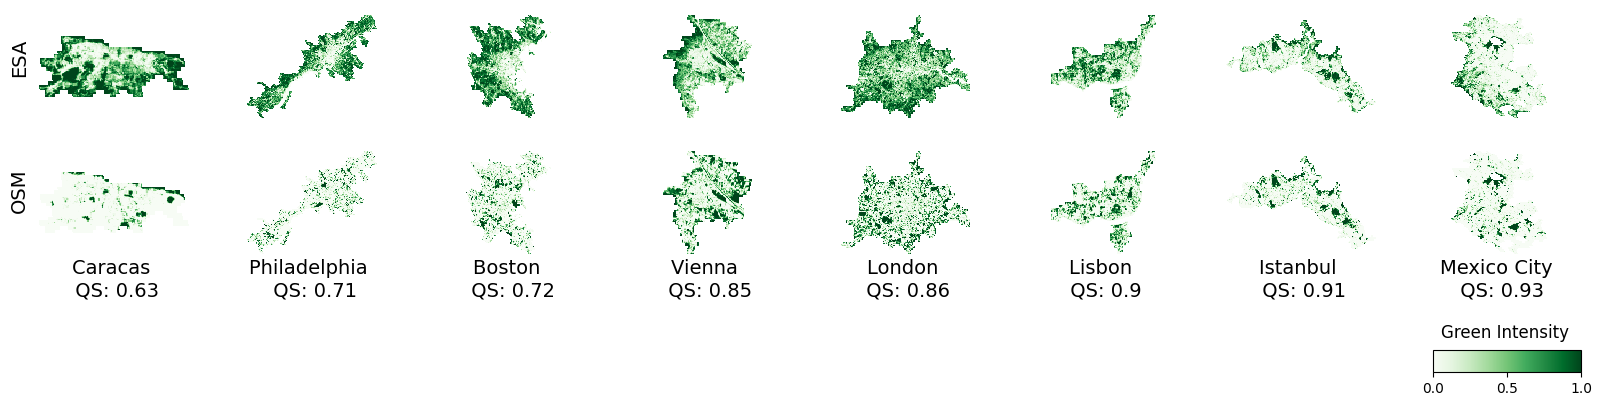

In [34]:
def mean_squares(df_orig, int1, int2, norm_factor):
    df=df_orig.copy()
    df['diff_squares']=df.apply(lambda x: ((x[int1]/norm_factor)-(x[int2]/norm_factor))**2, axis=1)
    ms=df['diff_squares'].mean()
    return ms, df

fig = plt.figure(figsize=(20,5))
for indc,city in enumerate(cities):
    
    pop_grid=query4grid(city, db_params)
    esa=queryRemappedGreen(city, "esa.esa2grid", '0_', 0, 0, db_params)
    osm=queryRemappedGreen(city, "osm.osm2grid", '0_', 0, 0, db_params)
    osm_confounders=queryRemappedGreen(city, "osm.osmconfounders2grid", '', 0, 0, db_params)
    osm_full=pd.concat([osm, osm_confounders])

    #Inbound only
    tmp_esa=pd.merge(pop_grid[pop_grid['inbound']==1][['x', 'y', 'geom']], esa.groupby(['x', 'y']).sum().reset_index(), on=['x', 'y'], how='left')
    tmp_osm=pd.merge(pop_grid[pop_grid['inbound']==1][['x', 'y']], osm_full.groupby(['x', 'y']).sum().reset_index(), on=['x', 'y'], how='left')
    tmp=pd.merge(tmp_esa, tmp_osm, on=['x', 'y'], how='outer', suffixes=('_esa', '_osm'))
    tmp=tmp.fillna(0)

    norm_factor=max(tmp['si_esa'].max(), project_gdf(pop_grid).area[0]/10000)
    tmp.loc[tmp['si_osm']>norm_factor,'si_osm']=norm_factor
    ms, tmp =mean_squares(tmp, 'si_esa', 'si_osm', norm_factor)
    ms_norm=1-(ms)
    
    tmp['si_esa_norm']=tmp['si_esa']/norm_factor
    tmp['si_osm_norm']=tmp['si_osm']/norm_factor
    
    quality=pd.merge(pop_grid[pop_grid['inbound']==1][['x', 'y', 'population']], tmp[['x', 'y', 'si_esa', 'si_osm','diff_squares']], on=['x', 'y'], how='left')
    
    pct_list=[0, 10, 20, 30, 40, 50, 60, 70, 80 , 90]
    base=list(np.percentile(quality['population'], pct_list))
    values=[1-quality[quality['population']>=b]['diff_squares'].mean() for b in base]
    
    ax=plt.subplot(3,8,indc+1)
    tmp.plot('si_esa_norm', cmap='Greens', ax=ax, norm=Normalize(vmin=0, vmax=1))
    if indc==0:
        ax.text(-0.13,0.4,'ESA', fontsize=14, transform=ax.transAxes, rotation=90)
    ax.axis('off')
    ax=plt.subplot(3,8,indc+9)
    tmp.plot('si_osm_norm', cmap='Greens', ax=ax, norm=Normalize(vmin=0, vmax=1))
    if indc==0:
        ax.text(-0.13,0.4,'OSM', fontsize=14, transform=ax.transAxes, rotation=90)
    ax.axis('off')
    ax=plt.subplot(3,8,indc+17)
    ax.axis('off')
    ax.set_title(f"{city.replace('_', ' ')} \n QS: {np.round(ms_norm, 2)}", size=14, y=0.8)
    if indc==7:
        in_ax=ax.inset_axes([0.1, 0.2, 0.9, 0.2])
        cbar=plt.colorbar(ScalarMappable(cmap='Greens', norm=Normalize(vmin=0, vmax=1)), orientation='horizontal', cax=in_ax)
        in_ax.text(0.15,0.5,'Green Intensity', fontsize=12, transform=ax.transAxes)

plt.savefig(f"{PATH}/Figures/Raw/Validation/Validation_1.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Raw/Validation/Validation_1.png", bbox_inches='tight', dpi=300)

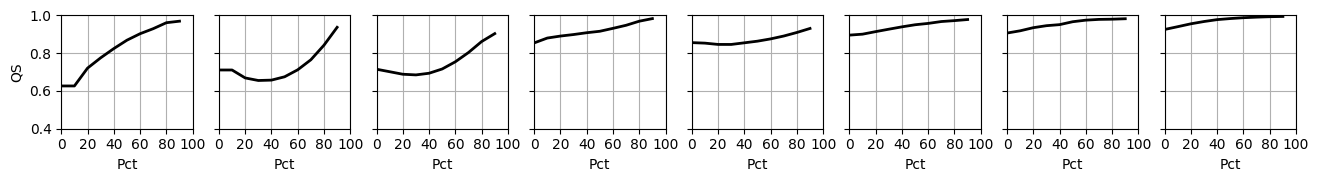

In [6]:
df=pd.read_csv(f"{PATH}/output/dataValidation/dataValiadtion_meansquareserror.csv")

fig = plt.figure(figsize=(20,5))    
for indc,city in enumerate(cities):
    
    pct_list=[0, 10, 20, 30, 40, 50, 60, 70, 80 , 90]
    values=ast.literal_eval(df[df['city']==city]['values_list'].values[0])
    
    ax=plt.subplot(3,10,indc+1)
    ax.plot(pct_list, values, color='black', linewidth=2)
    ax.set_ylim([0.4,1])
    ax.set_xlim([0,100])
    ax.set_yticks([0.4, 0.6, 0.8, 1])
    ax.set_xticks([0,20,40,60,80,100])
    ax.set_xlabel('Pct')
    if indc==0:
        ax.set_ylabel('QS')
    else:
        ax.set_ylabel('')
    if indc>0:
        ax.set_yticklabels(['','','',''])
   
    ax.grid()
    
plt.savefig(f"{PATH}/Figures/Raw/Validation/Validation_2.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Raw/Validation/Validation_2.png", bbox_inches='tight', dpi=300)

###### Compute additional statistics on overall average green intensity 

In [ ]:
for indc,city in tqdm(enumerate(cities_satysfyingR1)):
    
    pop_grid=query4grid(city, db_params)
    esa=queryRemappedGreen(city, "esa.esa2grid", '0_', 0, 0, db_params)
    tmp_esa=pd.merge(pop_grid[pop_grid['inbound']==1][['x', 'y', 'geom']], esa.groupby(['x', 'y']).sum().reset_index(), on=['x', 'y'], how='left')
    norm_factor=max(tmp_esa['si'].max(), project_gdf(pop_grid).area[0]/10000)
    tmp_esa['si_norm']=tmp_esa['si']/norm_factor
    
    df=pd.DataFrame({'city':[city], 
                     'average_green_intensity':[tmp_esa['si_norm'].mean()],
                     'size':[len(tmp_esa)]})
    if indc==0:
        df.to_csv(f"{PATH}/output/dataValidation/dataValiadtion_additionalstats.csv", mode='w', index=False)
    else:
        df.to_csv(f"{PATH}/output/dataValidation/dataValiadtion_additionalstats.csv", mode='a', index=False)

###### Clustering analysis to identify cities whose discrapancy is not aligned with the one of similar (in terms of size and average green intensity)cities in reference dataset.

In [23]:
### Load data and set reference dataset
df=pd.read_csv(f"{PATH}/output/dataValidation/dataValiadtion_meansquareserror.csv")
df1=pd.read_csv(f"{PATH}/output/dataValidation/dataValiadtion_additionalstats.csv")
df=pd.merge(df, df1, on=['city'], how='right')
df['continent']=df['ISO'].apply(lambda x: ISO_to_continent[x])
df['log_size']=df['size'].apply(lambda x: np.log(x))

### ISOs to be used as reference 
ISOs=['ITA', 'FRA', 'NLD','DEU','AUT', 'GBR', 'LUX', 'BEL','USA','CAN']

df_reference=df[df['ISO'].isin(ISOs)].copy()

###### Generate figures 

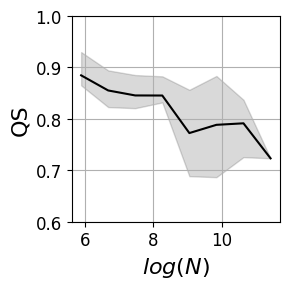

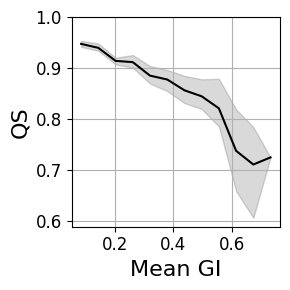

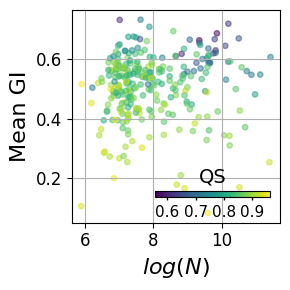

In [54]:
fig=plt.figure(figsize=(3,3))
ax=plt.subplot(111)
base=np.linspace(df_reference['log_size'].min(), df_reference['log_size'].max(), 8)
values_mean=[df_reference[(df_reference['log_size']<i) & (df_reference['log_size']>=base[ind])]['mean_squares_error_norm'].mean() for ind,i in enumerate(base[1:])]
values_mean.append(df_reference[(df_reference['log_size']>=max(base))]['mean_squares_error_norm'].mean())
values_25=[np.percentile(df_reference[(df_reference['log_size']<i) & (df_reference['log_size']>=base[ind])]['mean_squares_error_norm'], 25) for ind,i in enumerate(base[1:])]
values_25.append(np.percentile(df_reference[(df_reference['log_size']>=max(base))]['mean_squares_error_norm'], 25))
values_75=[np.percentile(df_reference[(df_reference['log_size']<i) & (df_reference['log_size']>=base[ind])]['mean_squares_error_norm'], 75) for ind,i in enumerate(base[1:])]
values_75.append(np.percentile(df_reference[(df_reference['log_size']>=max(base))]['mean_squares_error_norm'], 75))
ax.plot(base, values_mean, color='black')
ax.fill_between(base, values_25, values_75, color='black', alpha=0.15)
ax.set_xlabel(r'$log(N)$', size=16)
ax.set_ylabel('QS', size=16)
ax.set_xticks([6,8,10])
ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1])
ax.yaxis.set_tick_params(which='major', labelsize=12)
ax.xaxis.set_tick_params(which='major', labelsize=12)
ax.grid()
plt.tight_layout();

plt.savefig(f"{PATH}/Figures/Raw/Validation/Validation_4.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Raw/Validation/Validation_4.png", bbox_inches='tight', dpi=300)

base=np.linspace(df_reference['average_green_intensity'].min(), df_reference['average_green_intensity'].max(), 12)
values_mean=[df_reference[(df_reference['average_green_intensity']<i) & (df_reference['average_green_intensity']>=base[ind])]['mean_squares_error_norm'].mean() for ind,i in enumerate(base[1:])]
values_mean.append(df_reference[(df_reference['average_green_intensity']>=max(base))]['mean_squares_error_norm'].mean())
values_25=[np.percentile(df_reference[(df_reference['average_green_intensity']<i) & (df_reference['average_green_intensity']>=base[ind])]['mean_squares_error_norm'], 25) for ind,i in enumerate(base[1:])]
values_25.append(np.percentile(df_reference[(df_reference['average_green_intensity']>=max(base))]['mean_squares_error_norm'], 25))
values_75=[np.percentile(df_reference[(df_reference['average_green_intensity']<i) & (df_reference['average_green_intensity']>=base[ind])]['mean_squares_error_norm'], 75) for ind,i in enumerate(base[1:])]
values_75.append(np.percentile(df_reference[(df_reference['average_green_intensity']>=max(base))]['mean_squares_error_norm'], 75))


fig=plt.figure(figsize=(3,3))
ax=plt.subplot(111)
ax.plot(base, values_mean, color='black')
ax.fill_between(base, values_25, values_75, color='black', alpha=0.15)
ax.set_xlabel('Mean GI', size=16)
ax.set_ylabel('QS', size=16)
ax.set_xticks([0.2, 0.4, 0.6])
ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1])
ax.yaxis.set_tick_params(which='major', labelsize=12)
ax.xaxis.set_tick_params(which='major', labelsize=12)
ax.grid()
plt.tight_layout();

plt.savefig(f"{PATH}/Figures/Raw/Validation/Validation_5.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Raw/Validation/Validation_5.png", bbox_inches='tight', dpi=300)


fig=plt.figure(figsize=(3,3))
ax = plt.subplot(111)
ax.scatter(df_reference['log_size'], df_reference['average_green_intensity'], c=df_reference['mean_squares_error_norm'], cmap='viridis', norm=Normalize(vmin=df_reference['mean_squares_error_norm'].min(), vmax=df_reference['mean_squares_error_norm'].max()), s=15, alpha=0.5)
ax.set_ylabel('Mean GI', size=16)
ax.set_xlabel(r'$log(N)$', size=16)
ax.set_yticks([0.2, 0.4, 0.6])
ax.set_xticks([6,8,10])
ax.yaxis.set_tick_params(which='major', labelsize=12)
ax.xaxis.set_tick_params(which='major', labelsize=12)
ax.grid()
in_ax=ax.inset_axes([0.4, 0.12, 0.55, 0.03])
cbar=plt.colorbar(ScalarMappable(cmap='viridis', norm=Normalize(vmin=df_reference['mean_squares_error_norm'].min(), vmax=df_reference['mean_squares_error_norm'].max())), orientation='horizontal', cax=in_ax, ticks=[0.6, 0.7, 0.8, 0.9])
cbar.ax.set_title('QS', size=14)
cbar.ax.yaxis.set_tick_params(which='major', labelsize=11, width=1, size=2)
cbar.ax.xaxis.set_tick_params(which='major', labelsize=11, width=1, size=2)

plt.tight_layout();

plt.savefig(f"{PATH}/Figures/Raw/Validation/Validation_6.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Raw/Validation/Validation_6.png", bbox_inches='tight', dpi=300)

###### Perform cluster analysis

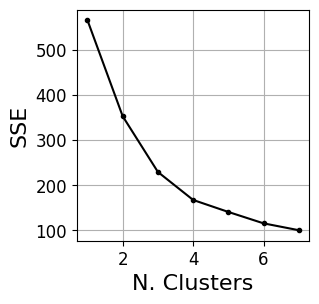

In [55]:
df_forcluster=df_reference[['city','log_size', 'average_green_intensity', 'mean_squares_error_norm']].copy()
scaler = StandardScaler()
scaler.fit(df_forcluster[['log_size', 'average_green_intensity']])
X=scaler.transform(df_forcluster[['log_size', 'average_green_intensity']])

# elbow method to identify optimal value of K
sse = []
for k in range(1, 8):
    km = KMeans(n_clusters=k, n_init='auto')
    km.fit(X)
    sse.append(km.inertia_)

# plot to identify the elbow
fig=plt.figure(figsize=(3, 3))
ax=plt.subplot(111)
ax.plot(range(1, 8), sse, '-o', markersize=3, c = 'black')
ax.set_xlabel('N. Clusters', size=16)
ax.grid()
ax.set_ylabel('SSE', size=16)
ax.yaxis.set_tick_params(which='major', labelsize=12)
ax.xaxis.set_tick_params(which='major', labelsize=12)

plt.savefig(f"{PATH}/Figures/Raw/Validation/Validation_7.pdf", bbox_inches='tight', dpi=300, transparent=True)
plt.savefig(f"{PATH}/Figures/Raw/Validation/Validation_7.png", bbox_inches='tight', dpi=300, transparent=True)

In [56]:
#Run model
kmeans = KMeans(n_clusters=4, n_init='auto')
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# visualize centriods on data
centriods = kmeans.cluster_centers_

df_forcluster['cluster']=y_kmeans
centroids_transformed=scaler.inverse_transform(centriods)

#Identify decision boundaries
### Identify decision boundary
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ms_inverse_x=scaler.inverse_transform(np.column_stack((xx[0],xx[0])))[:,0]
ms_inverse_y=scaler.inverse_transform(np.column_stack((np.transpose(yy)[0],np.transpose(yy)[0])))[:,1]

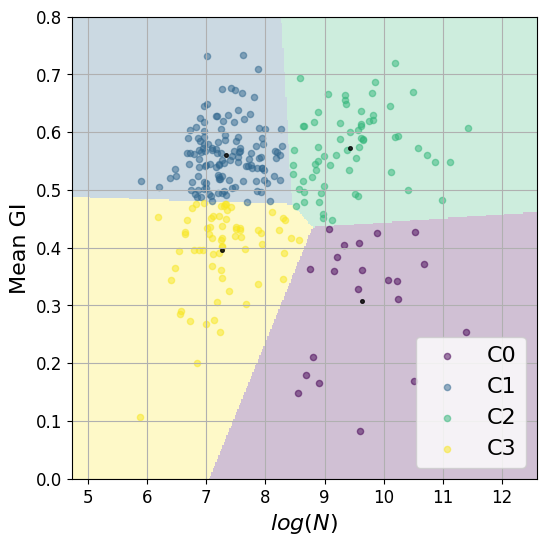

In [57]:
# train model
clusters_colors={'0': get_cmap('viridis')(0),'1':get_cmap('viridis')(0.33),'2':get_cmap('viridis')(0.66),'3':get_cmap('viridis')(0.99)}

fig=plt.figure(figsize=(6, 6))
ax=plt.subplot(111)
#Plot points and centroids
for i in range(4):
    ax.scatter(df_forcluster[df_forcluster['cluster']==i]['log_size'], df_forcluster[df_forcluster['cluster']==i]['average_green_intensity'],color=clusters_colors[str(i)], s=20,alpha = 0.5, label=f"C{str(i)}")
ax.scatter(centroids_transformed[:, 0], centroids_transformed[:, 1], color='black',s=7,alpha=0.8)
ax.grid()
ax.set_ylim([0,0.8])
ax.set_ylabel('Mean GI', size=16)
ax.set_xlabel(r'$log(N)$', size=16)
ax.yaxis.set_tick_params(which='major', labelsize=12)
ax.xaxis.set_tick_params(which='major', labelsize=12)
ax.legend(fontsize=16)

ax.imshow(Z, interpolation='nearest',
       extent=(ms_inverse_x.min(), ms_inverse_x.max(), ms_inverse_y.min(), ms_inverse_y.max()),
       cmap='viridis',
       aspect='auto', origin='lower', alpha=0.25);
plt.savefig(f"{PATH}/Figures/Raw/Validation/Validation_8.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{PATH}/Figures/Raw/Validation/Validation_8.png", bbox_inches='tight', dpi=300)

In [58]:
### For each cluster, identify interval of admitted values
clusters_lowerbound={}
clusters_upperbound={}
for i in range(4):
    clusters_lowerbound[str(i)]=np.percentile(df_forcluster[df_forcluster['cluster']==i]['mean_squares_error_norm'], 10)
    clusters_upperbound[str(i)]=np.percentile(df_forcluster[df_forcluster['cluster']==i]['mean_squares_error_norm'], 90)
                          
print(clusters_lowerbound)
print(clusters_upperbound)

{'0': 0.8640928270973087, '1': 0.7641853923163668, '2': 0.6391975684722608, '3': 0.8302976170544475}
{'0': 0.9365111553056148, '1': 0.9157172906148794, '2': 0.8597074105190233, '3': 0.9362540096851332}


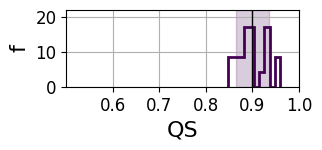

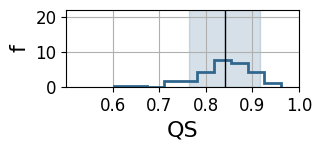

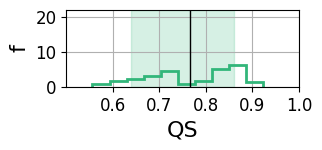

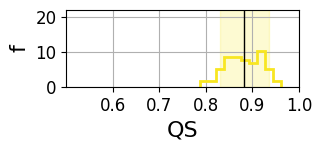

In [61]:
#Plot distribution of QS for each cluster
for i in range(4):
    fig=plt.figure(figsize=(3,1))
    ax=plt.subplot(111)
    ax.hist(df_forcluster[df_forcluster['cluster']==i]['mean_squares_error_norm'], histtype='step', linewidth=2, color=clusters_colors[str(i)], density=True)
    ax.set_xlim([0.5,1])
    ax.set_ylim([0, 22])
    ax.set_yticks([0, 10,20])
    ax.set_xticks([0.6, 0.7, 0.8, 0.9, 1])
    ax.grid()
    ax.set_xlabel('QS', size=16)
    ax.set_ylabel('f', size=16)
    ax.yaxis.set_tick_params(which='major', labelsize=12)
    ax.xaxis.set_tick_params(which='major', labelsize=12)
    ax.axvline(df_forcluster[df_forcluster['cluster']==i]['mean_squares_error_norm'].mean(), 0, 20, color='black', linewidth=1)
    ax.fill_betweenx([0, 22], [clusters_lowerbound[str(i)], clusters_lowerbound[str(i)]], [clusters_upperbound[str(i)], clusters_upperbound[str(i)]], color=clusters_colors[str(i)], alpha=0.2)
    plt.savefig(f"{PATH}/Figures/Raw/Validation/Validation_{str(i+9)}.pdf", bbox_inches='tight', dpi=300)
    plt.savefig(f"{PATH}/Figures/Raw/Validation/Validation_{str(i+9)}.png", bbox_inches='tight', dpi=300)

In [62]:
### Identify corresponding cluster for other cities
df_predict=df[df['city'].isin(list(df_reference['city']))==False][['city','log_size', 'average_green_intensity', 'mean_squares_error_norm']].copy()
X_predict=scaler.transform(df_predict[['log_size', 'average_green_intensity']])
df_predict['cluster'] = kmeans.predict(X_predict)
df_predict['keep']=df_predict.apply(lambda x:  1 if (x['mean_squares_error_norm']>clusters_lowerbound[str(int(x['cluster']))]) & (x['mean_squares_error_norm']<clusters_upperbound[str(int(x['cluster']))]) else 0 , axis=1)

In [63]:
cities_satysfyingR2=list(df_predict[df_predict['keep']==1]['city']) + list(df_reference['city'])
cities_notsatysfyingR2=list(df_predict[df_predict['keep']==0]['city'])

print(len(cities_satysfyingR2))
print(len(cities_notsatysfyingR2))

pd.DataFrame({'city':cities_satysfyingR2}).to_csv(f"{PATH}/output/dataValidation/CitiesSatisfyingR2.csv")
pd.DataFrame({'city':cities_notsatysfyingR2}).to_csv(f"{PATH}/output/dataValidation/CitiesNotSatisfyingR2.csv")

1040
923


In [50]:
df_predict=df_predict.rename(columns={'mean_squares_error_norm':'QualityScore', 'keep':'Included'})
df_reference=df_reference.rename(columns={'mean_squares_error_norm':'QualityScore'})
df_reference['Included']=1
df_predict.to_csv(f"{PATH}/output/dataValidation/df_predict.csv", index=False)
df_reference.to_csv(f"{PATH}/output/dataValidation/df_reference.csv", index=False)

In [5]:
### Load files to characterize cities with quality scores
df_predict=pd.read_csv('../output/dataValidation/df_predict.csv').rename(columns={'Included':'included_paper', 'QualityScore':'qualityScore'})
df_reference=pd.read_csv('../output/dataValidation/df_reference.csv').rename(columns={'Included':'included_paper', 'QualityScore':'qualityScore'})
df_all=gpd.read_file('processed_data/ghs_ucdb/cities_boundary.geojson')[['city']]
df_excluded_stage1=df_all[(df_all['city'].isin(list(df_predict['city']))==False) & (df_all['city'].isin(list(df_reference['city']))==False)].copy()
df_excluded_stage1['qualityScore']=-1
df_excluded_stage1['included_paper']=-1


#Load into unique df
df_toload=pd.concat([df_predict[['city','qualityScore', 'included_paper']], df_reference[['city','qualityScore', 'included_paper']], df_excluded_stage1[['city','qualityScore', 'included_paper']]]).reset_index(drop=True)

#Load into table
df2psql(df_toload, 'qualityscore', db_params, index=False,index_label='city')

conn = psycopg2.connect(
dbname=db_params['db_name'], user=db_params['db_user'], password=db_params['db_password'], host=db_params['db_host'])
conn.autocommit=True
with conn.cursor() as cur: 
    cur.execute("""SELECT cb.*, "qualityScore", "included_paper"
                   INTO   cities_boundary2
                   FROM qualityscore qs
                   JOIN  cities_boundary cb 
                   ON cb.city = qs.city """)
    cur.execute("""DROP TABLE qualityscore""")
    cur.execute("""DROP TABLE cities_boundary""")
    cur.execute("""ALTER TABLE cities_boundary2 RENAME TO cities_boundary""")
conn.close()